In [17]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

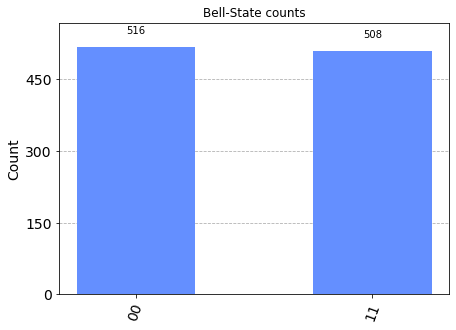

In [18]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

# Excited state solvers in qiskit

In [19]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 10",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [20]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

In [21]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver

numpy_solver = NumPyEigensolver(k=4, filter_criterion=es_problem.get_default_filter_criterion())

In [22]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.algorithms.excited_states_solvers.qeom import EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
solver = VQE(estimator, ansatz, SLSQP())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)

In [23]:
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver

numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(es_problem)

qeom_results = qeom_excited_states_solver.solve(es_problem)

print(numpy_results)
print("\n\n")
print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -0.986081420207
  - computed part:      -0.986081420207
~ Nuclear repulsion energy (Hartree): 0.052917721092
> Total ground state energy (Hartree): -0.933163699115
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.264393197379
> Total excited state energy (Hartree): -0.211475476287
  2: 
* Electronic excited state energy (Hartree): -0.264393197379
> Total excited state energy (Hartree): -0.211475476287
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  18.89726125]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  18.897261245651]
    - computed part:      [0.0  0.0  18.897261245651]
  > Dipole moment (a.u.): [0.0  0.0  0.000000004349]  Total: 0.000000004349


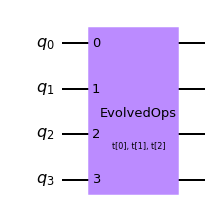

In [24]:
ansatz.draw(output='mpl')

In [25]:
ansatz.draw()

┌─────────────────────────────┐
q_0: ┤0                            ├
     │                             │
q_1: ┤1                            ├
     │  EvolvedOps(t[0],t[1],t[2]) │
q_2: ┤2                            ├
     │                             │
q_3: ┤3                            ├
     └─────────────────────────────┘

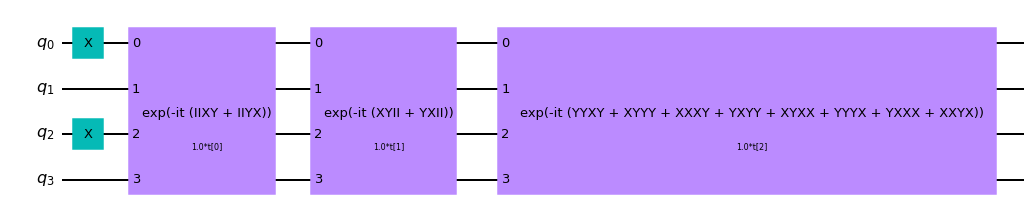

In [26]:
ansatz.decompose().draw(output='mpl')

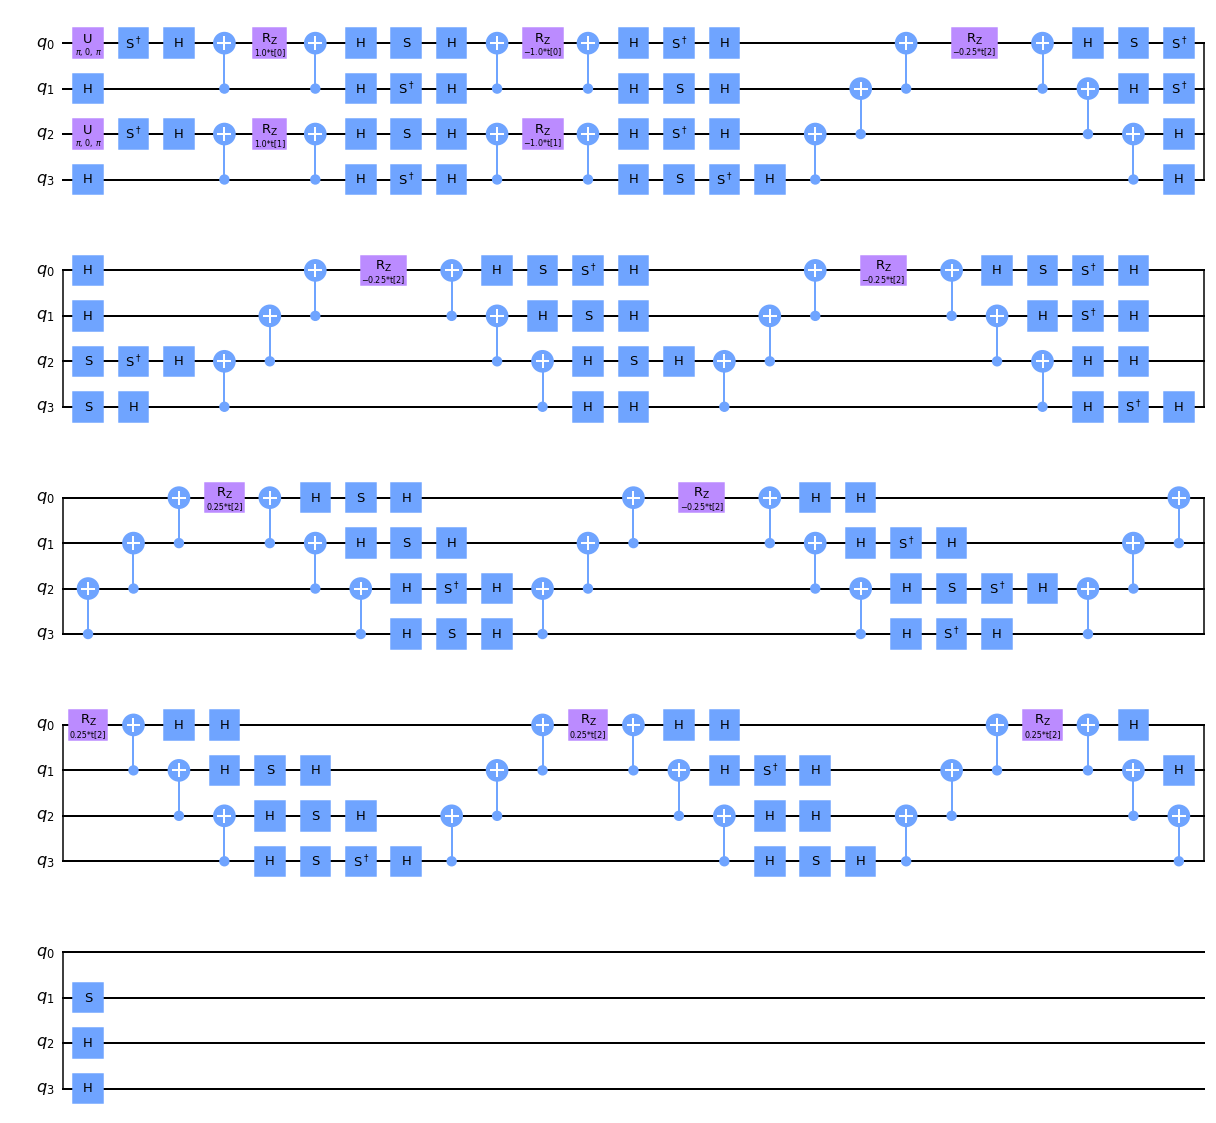

In [27]:
ansatz.decompose().decompose().decompose().draw(output='mpl')